In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [16]:
ratings_df = pd.read_csv("ratings.csv")
architects_df = pd.read_csv("books.csv")

ratings_df.head()

,user_id,architect_id,rating
0,37,967,0
1,76,82,9
2,94,486,9
3,61,271,2
4,30,467,0


In [5]:
architects_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [17]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.architect_id.nunique())
ratings_df.isna().sum()

(2000, 3)
100
875


user_id         0
architect_id    0
rating          0
dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (1600, 3)
Shape of test data: (400, 3)


In [19]:
#Get the number of unique entities in architects and users columns
narchitect_id = ratings_df.architect_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [20]:
#Architect input network
input_architect = tf.layers.Input(shape=[1])
embed_archtitect = tf.layers.Embedding(narchitect_id + 1,15)(input_architect)
architects_out = tf.layers.Flatten()(embed_archtitect)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([architects_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_architect, input_users], x_out)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 15)        13140       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 15)        1515        input_4[0][0]                    
_______________________________________________________________________________________

In [23]:
#Fit and evaluate model
hist = model.fit(
    [Xtrain.architect_id, Xtrain.user_id],
    Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.architect_id, Xtest.user_id], Xtest.rating)
                )

Epoch 1/5


InvalidArgumentError:  indices[0,0] = 905 is not in [0, 876)
	 [[node functional_3/embedding_2/embedding_lookup (defined at <ipython-input-22-62e5ddfe83ad>:2) ]] [Op:__inference_train_function_1689]

Errors may have originated from an input operation.
Input Source operations connected to node functional_3/embedding_2/embedding_lookup:
 functional_3/embedding_2/embedding_lookup/1447 (defined at /usr/lib/python3.8/contextlib.py:113)

Function call stack:
train_function


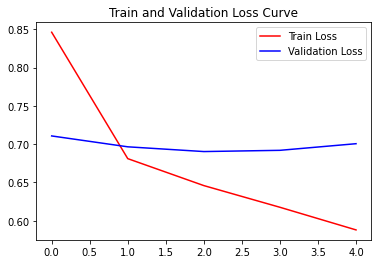

In [37]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title('Train and Validation Loss Curve')
plt.legend()
plt.show()

In [38]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [41]:
book_em = model.get_layer('embedding_6')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [42]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index('book_id')

In [ ]:
b_id = list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for